# 07MBIG - Visualización - Trabajo Práctico - Generar Dataset

## Importar librerías

In [ ]:
#Importamos modulos
import pandas as pd
import numpy as np
import io
from google.colab import files
import requests
import seaborn as sns
import timeit
import matplotlib.pyplot as plt

## Cargar dataset

Cargamos el dataset descargado de:

https://www.kaggle.com/diegoandresm/global-warmingpollution-by-economic-sector


In [ ]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), error_bad_lines=False, sep=';')
    return df

df = upload_files(['country', 'year'])

Saving pollution by sectors and countries.csv to pollution by sectors and countries.csv
User uploaded file "pollution by sectors and countries.csv" with length 4052730 bytes


## Explorar dataset

In [ ]:
#Informacion del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24651 entries, 0 to 24650
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             21489 non-null  object 
 1   country                              24651 non-null  object 
 2   year                                 24651 non-null  int64  
 3   co2                                  23403 non-null  float64
 4   consumption_co2                      3815 non-null   float64
 5   co2_growth_prct                      24383 non-null  float64
 6   co2_growth_abs                       23042 non-null  float64
 7   trade_co2                            3815 non-null   float64
 8   co2_per_capita                       22735 non-null  float64
 9   consumption_co2_per_capita           3815 non-null   float64
 10  share_global_co2                     23403 non-null  float64
 11  cumulative_co2              

In [ ]:
# Seleccionar columnas de interés
#df2 = df[['iso_code', 'country', 'year', 'co2','co2_per_capita', 'coal_co2','cement_co2','flaring_co2','gas_co2','oil_co2','other_industry_co2', 'coal_co2_per_capita', 'cement_co2_per_capita', 'flaring_co2_per_capita', 'gas_co2_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita', 'population']]
df2 = df[['iso_code', 'country', 'year', 'co2', 'coal_co2','cement_co2','flaring_co2','gas_co2','oil_co2','other_industry_co2']]
df2 = df2.fillna(0)
df2.head()

,iso_code,country,year,co2,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2
0,AFG,Afghanistan,1949,15.0,15.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Afghanistan,1950,84.0,21.0,0.0,0.0,0.0,63.0,0.0
2,AFG,Afghanistan,1951,92.0,26.0,0.0,0.0,0.0,66.0,0.0
3,AFG,Afghanistan,1952,92.0,32.0,0.0,0.0,0.0,6.0,0.0
4,AFG,Afghanistan,1953,106.0,38.0,0.0,0.0,0.0,68.0,0.0


## Filtros


En este apartado se van a filtrar los datos outliers. Primero la contaminación para cada sector a los largo de los años donde se puede observar que hay picos cercanos a 0 los cuales deben de ser filtrados.

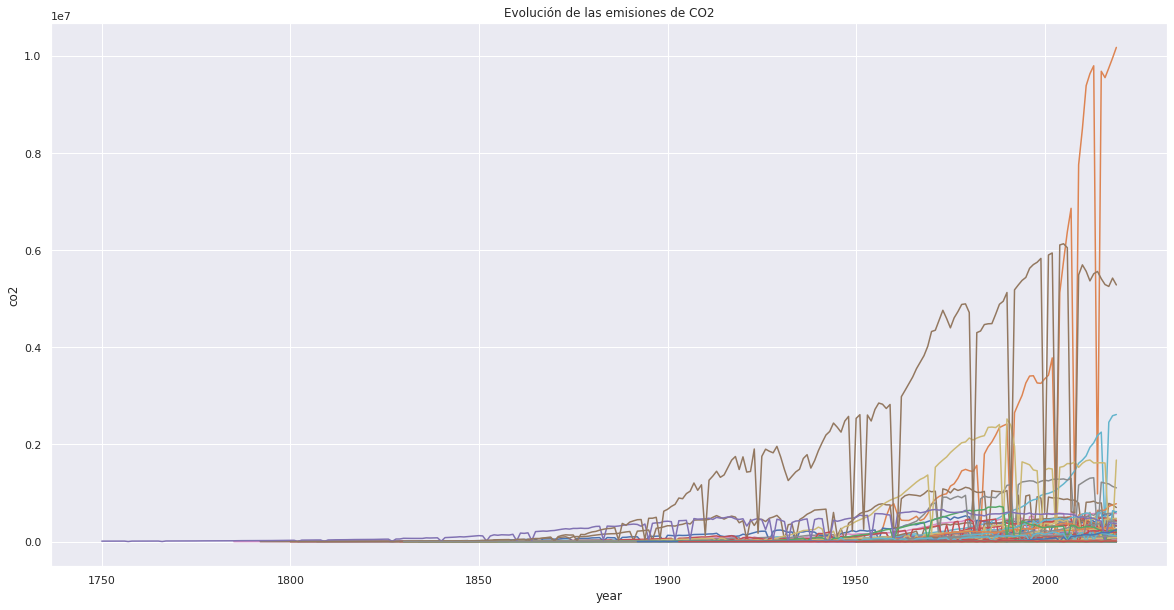

In [ ]:
df2 = df2[(df2.iso_code != '0') & (df2.co2 > 0) & (df2.iso_code != 0) & (df2.iso_code != 'OWID_WRL') & (df2.iso_code != '')]
df2.reset_index(drop=True, inplace=True)


maximo = []
sns.set(rc={'figure.figsize':(20,10)})
for e in df2['iso_code'].unique():
  sns.lineplot(x=df2[ df2.iso_code == e ]['year'], y=df2[ df2.iso_code == e ]['co2'])

plt.title("Evolución de las emisiones de CO2")
plt.show()


Para ellos e va a interpolar ese pico entre dos valores validos, el anterior y el siguiente.

In [ ]:
# Filtrar los datos que parece que están divididos /10
def filtraRuido(paises, columna, limite):

  current_code = paises[0]
  last_value = columna[0]

  diff_arr = []
  for index in range(len(columna)):
    if index+1 >= len(columna):
      # No sumar, es la última
      diff_arr.append(1)
    else:
      if current_code == paises[index]: # Seguimos en el mismo pais
        current_value = columna[index]
        next_value = columna[index+1]
        diff =  ((last_value + next_value)/2)/current_value
        if diff > limite:
          diff_arr.append(diff)
        else:
          diff_arr.append(1)
        last_value = current_value
      else: # cambio de pais
        current_code = paises[index]
        last_value = columna[index]
        diff_arr.append(1)

  return columna * diff_arr

df2['co2'] = filtraRuido(df2['iso_code'], df2['co2'], 4)
df2['coal_co2'] = filtraRuido(df2['iso_code'], df2['coal_co2'], 4)
df2['cement_co2'] = filtraRuido(df2['iso_code'], df2['cement_co2'], 4)
df2['flaring_co2'] = filtraRuido(df2['iso_code'], df2['flaring_co2'], 4)
df2['gas_co2'] = filtraRuido(df2['iso_code'], df2['gas_co2'], 4)
df2['oil_co2'] = filtraRuido(df2['iso_code'], df2['oil_co2'], 4)
df2['other_industry_co2'] = filtraRuido(df2['iso_code'], df2['other_industry_co2'], 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


Una vez filtrado se vuelve a graficar para verficar que los datos espúreos han sido filtrados correctamente.

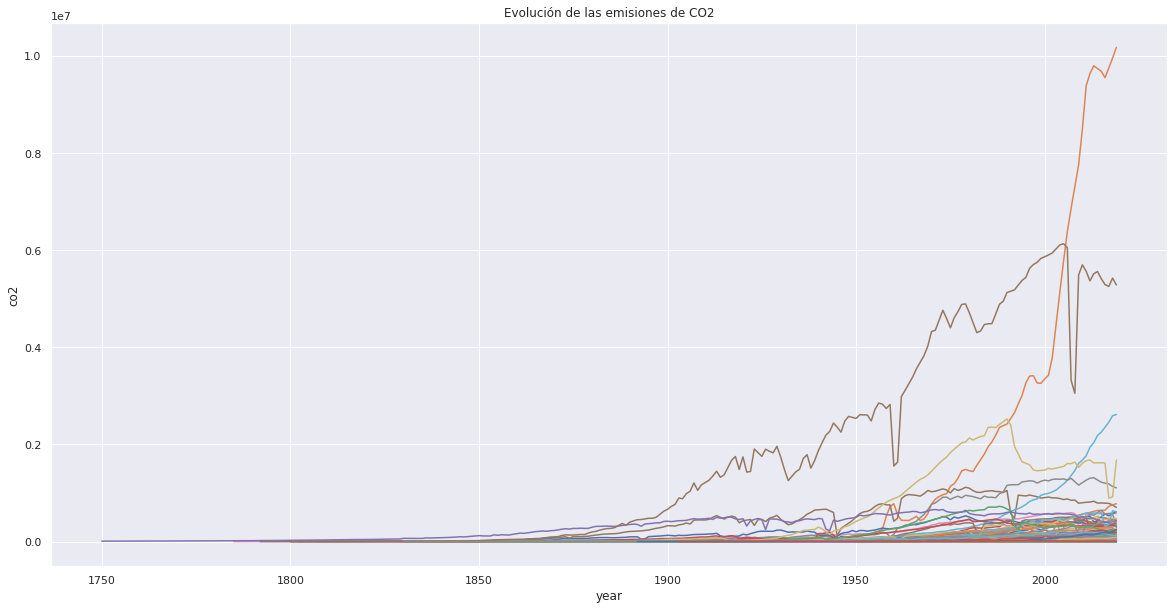

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
for e in df2['iso_code'].unique():
    sns.lineplot(x=df2[ df2.iso_code == e ]['year'], y=df2[ df2.iso_code == e ]['co2'], legend=True)

plt.title("Evolución de las emisiones de CO2")
plt.show()

In [ ]:
df2.to_csv('final_dataset.csv') 
files.download('final_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>